 # 2020 FINTECH MODELING CONTEST 
 ------------------------------------------------------------------------------------------------------
 ## by 41819045  **蒋中一**

# 1 获取数据及初步观察

In [5]:
'''
2020 fintech modeling contest
蒋中一 41819045
18 经管学院
Python
'''
#引用库
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os

warnings.filterwarnings('ignore')

sns.set_style('whitegrid')

%matplotlib inline

In [8]:
os.getcwd()

'/Users/jiiangzhongy/金融科技大赛'

In [9]:
#获取训练集和测试集
train_data=pd.read_csv(r'/Users/jiiangzhongy/Desktop/金融科技建模比赛/Final Result_41819045/LGD training.csv')
test_data=pd.read_csv(r'/Users/jiiangzhongy/Desktop/金融科技建模比赛/Final Result_41819045/LGD TEST.csv')

FileNotFoundError: [Errno 2] File b'/Users/jiiangzhongy/Desktop/\xe9\x87\x91\xe8\x9e\x8d\xe7\xa7\x91\xe6\x8a\x80\xe6\xaf\x94\xe8\xb5\x9b/Final Result_41819045/LGD training.csv' does not exist: b'/Users/jiiangzhongy/Desktop/\xe9\x87\x91\xe8\x9e\x8d\xe7\xa7\x91\xe6\x8a\x80\xe6\xaf\x94\xe8\xb5\x9b/Final Result_41819045/LGD training.csv'

In [3]:
#观察前几行的数据源
train_data.head()

,id,Label,loan_amnt,grade,home_ownership,annual_inc,purpose,dti,delinq_2yrs,fico_range_high,...,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit
0,1,0,25200,C,RENT,76280.0,debt_consolidation,32.87,0,689,...,0,2,100.0,100.0,1,0,84576,59295,6000,70876
1,2,1,20000,B,MORTGAGE,65000.0,debt_consolidation,28.88,1,689,...,0,1,86.7,50.0,0,0,351485,93039,19800,86925
2,3,1,5000,C,OWN,43000.0,debt_consolidation,17.83,0,744,...,0,1,100.0,33.3,0,0,39100,16253,13800,17000
3,4,0,8825,C,RENT,32000.0,debt_consolidation,21.49,0,694,...,0,1,94.4,0.0,0,0,26200,16509,14200,12000
4,5,1,16000,C,RENT,50000.0,debt_consolidation,38.32,0,679,...,0,1,76.5,50.0,0,0,108351,64596,11500,92851


In [4]:
#观察数据信息
train_data.info()
print('-'* 40)
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75046 entries, 0 to 75045
Data columns (total 73 columns):
id                                75046 non-null int64
Label                             75046 non-null int64
loan_amnt                         75046 non-null int64
grade                             75046 non-null object
home_ownership                    75046 non-null object
annual_inc                        75046 non-null float64
purpose                           75046 non-null object
dti                               75046 non-null float64
delinq_2yrs                       75046 non-null int64
fico_range_high                   75046 non-null int64
inq_last_6mths                    75046 non-null int64
mths_since_last_delinq            38956 non-null float64
mths_since_last_record            15418 non-null float64
open_acc                          75046 non-null int64
pub_rec                           75046 non-null int64
revol_bal                         75046 non-null int64


从上面可以看出，mths_since_last_delinq，mths_since_last_record，mths_since_recent_bc_dlq 等多个特征存在缺失

绘制LGD比例：

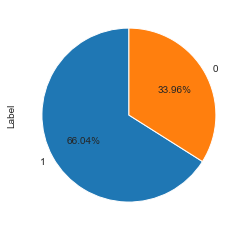

In [5]:
#绘制LGD比例图
train_data['Label'].value_counts().plot.pie(labeldistance = 1.1,autopct = '%1.2f%%',
                                               shadow = False,startangle = 90,pctdistance = 0.6)

# 2 数据清洗

## 2.1数据的初步规整

In [6]:
#将['revol_util']数据类型改为 float
for i in range(0,len(train_data['revol_util'])):
    if type(train_data.loc[i]['revol_util'])== str:
        train_data.loc[i,'revol_util']=round(float(train_data.loc[i]['revol_util'][:-1])/100,4)

## 2.2处理缺失值

从前面发现，revol_util的缺失值很少，可以用平均数进行填充：

In [8]:
#用平均数填充'revol_util'中的缺失值
train_data.revol_util[train_data.revol_util.isnull()] = train_data.revol_util.dropna().mean()

其他缺失值很少的数值型指标，也用平均值进行填充：

In [9]:
for i in ['open_acc_6m','open_act_il','open_il_12m','open_il_24m',
          'mths_since_rcnt_il','total_bal_il','il_util','open_rv_12m'
          ,'open_rv_24m','max_bal_bc','all_util','inq_fi','total_cu_tl'
         ,'inq_last_12m','avg_cur_bal','bc_open_to_buy','bc_util','mo_sin_old_il_acct'
         ,'mths_since_recent_bc','mths_since_recent_inq','num_tl_120dpd_2m','percent_bc_gt_75']:
    train_data.loc[train_data[i].isnull(),i]= round(train_data[i].dropna().mean(),2)

# 3 理解数据（EDA）

##  3.1 贷款等级和LGD的关系

In [10]:
train_data.groupby(['grade','Label'])['grade'].count()

grade  Label
A      0         3555
       1         3344
B      0         7235
       1        13236
C      0         7934
       1        18380
D      0         4702
       1        10392
E      0         1686
       1         3182
F      0          288
       1          719
G      0           89
       1          304
Name: grade, dtype: int64

In [11]:
train_data[['grade','Label']].groupby(['grade']).mean()

,Label
grade,
A,0.484708
B,0.646573
C,0.698487
D,0.688485
E,0.653657
F,0.714002
G,0.773537


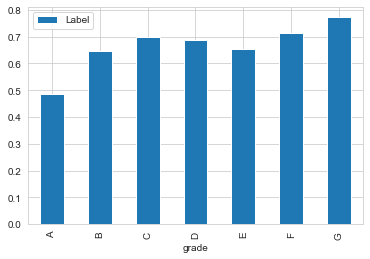

In [12]:
train_data[['grade','Label']].groupby(['grade']).mean().plot.bar()

可以从图上明显看出，随着贷款等级的下降，违约情况增多

## 3.2 房屋所有权状态与LGD的关系

In [13]:
train_data.groupby(['home_ownership','Label'])['home_ownership'].count()

home_ownership  Label
ANY             0           43
                1           44
MORTGAGE        0         9160
                1        18170
OWN             0         3407
                1         6537
RENT            0        12879
                1        24806
Name: home_ownership, dtype: int64

In [14]:
train_data[['home_ownership','Label']].groupby(['home_ownership']).mean()

,Label
home_ownership,
ANY,0.505747
MORTGAGE,0.664837
OWN,0.657381
RENT,0.658246


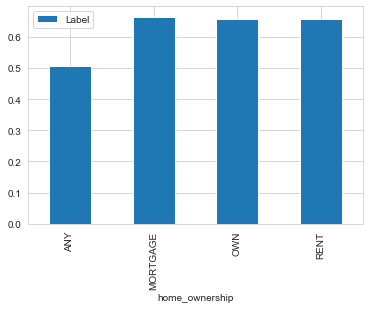

In [15]:
train_data[['home_ownership','Label']].groupby(['home_ownership']).mean().plot.bar()

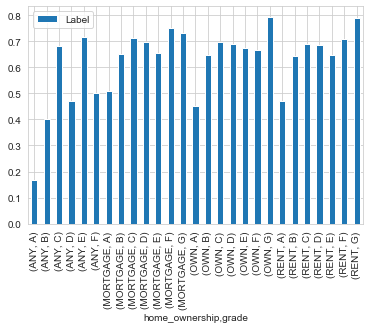

In [16]:
train_data[['grade','home_ownership','Label']].groupby(['home_ownership','grade']).mean().plot.bar()

从上面的图和表可以看出，房产状态为ANY的客户，LGD较低，而其他客户，LGD都差不多，但对于不同贷款等级，还是有明显差别的

## 3.3 贷款金额与LGD之间的关系
首先绘制贷款金额的分布情况：

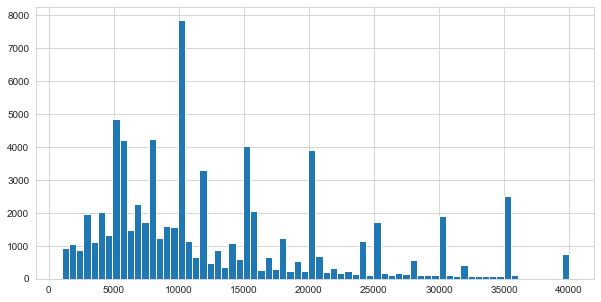

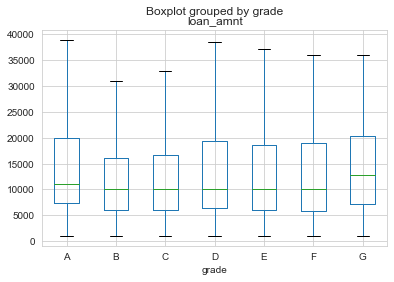

In [17]:
plt.figure(figsize=(10,5))
train_data['loan_amnt'].hist(bins=70)
 
train_data.boxplot(column='loan_amnt', by='grade', showfliers=False)
plt.show()

In [18]:
print(train_data['loan_amnt'].describe())

count    75046.000000
mean     13047.744383
std       8866.705182
min       1000.000000
25%       6100.000000
50%      10000.000000
75%      17950.000000
max      40000.000000
Name: loan_amnt, dtype: float64


绘制LGD与贷款金额均值和方差的关系：

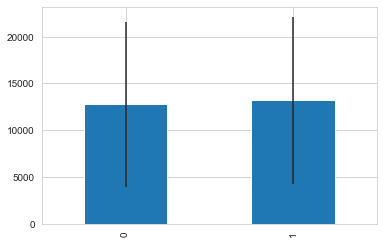

In [19]:
fare_not_survived = train_data['loan_amnt'][train_data['Label'] == 0]
fare_survived = train_data['loan_amnt'][train_data['Label'] == 1]
 
average_fare = pd.DataFrame([fare_not_survived.mean(),fare_survived.mean()])
std_fare = pd.DataFrame([fare_not_survived.std(),fare_survived.std()])
average_fare.plot(yerr=std_fare,kind='bar',legend=False)
 
plt.show()



由上图表可知，贷款金额与LGD无明显关系

## 3.4 贷款用途与LGD之间的关系

In [20]:
train_data.groupby(['purpose','Label'])['purpose'].count()

purpose             Label
car                 0          256
                    1          486
credit_card         0         5360
                    1         9251
debt_consolidation  0        13904
                    1        27902
home_improvement    0         1566
                    1         3205
house               0          206
                    1          414
major_purchase      0          643
                    1         1198
medical             0          475
                    1          844
moving              0          267
                    1          544
other               0         2127
                    1         4250
renewable_energy    0           23
                    1           46
small_business      0          406
                    1          876
vacation            0          256
                    1          540
wedding             1            1
Name: purpose, dtype: int64

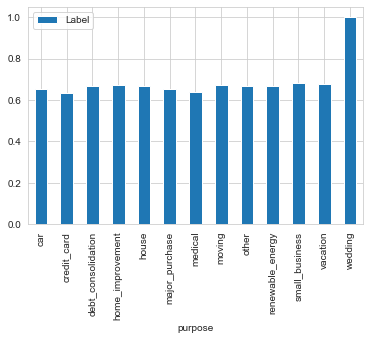

In [21]:
train_data[['purpose','Label']].groupby(['purpose']).mean().plot.bar()

从上图可以看出，用途对LGD影响不大，wedding出现很大差异的原因是数据量只有一个，不具有参考价值

## 3.5 年收入与LGD之间的关系
分别分析不同贷款等级和不同房屋状态下，年收入分布和LGD的关系：

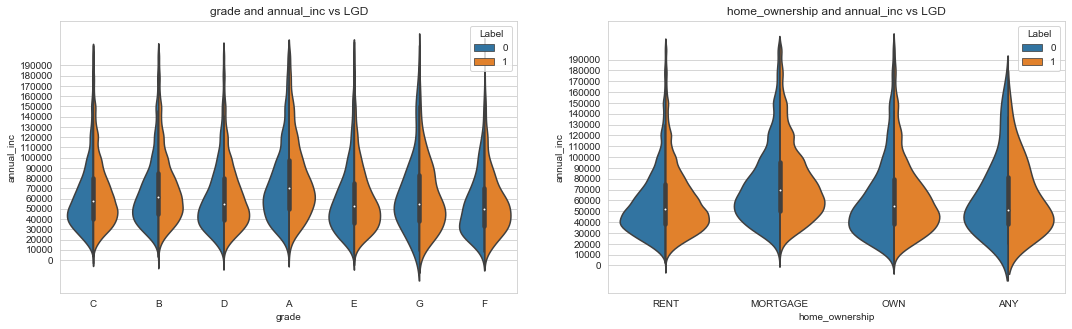

In [22]:
fig,ax = plt.subplots(1,2, figsize = (18,5))
ax[0].set_yticks(range(0,200000,10000))
sns.violinplot("grade","annual_inc",hue="Label",data=train_data[train_data['annual_inc']<=200000],split=True,ax=ax[0])
ax[0].set_title('grade and annual_inc vs LGD') 

ax[1].set_yticks(range(0,200000,10000))
sns.violinplot("home_ownership","annual_inc",hue="Label",data=train_data[train_data['annual_inc']<=200000],split=True,ax=ax[1])
ax[1].set_title('home_ownership and annual_inc vs LGD')
 
plt.show()

由上图可以看出，房产状态和贷款等级的分组对 年收入与LGD的关系 的影响，很显著

不同年收入下，LGD的分布情况:

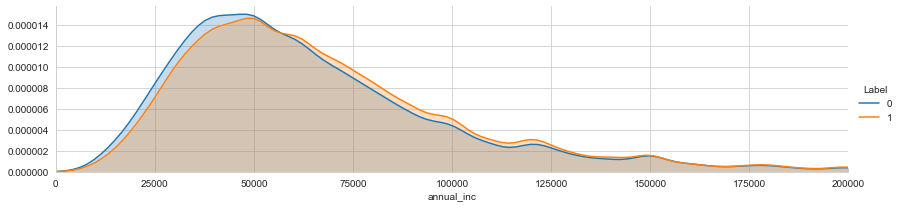

In [23]:
facet = sns.FacetGrid(train_data[train_data['annual_inc']<=200000],hue="Label",aspect=4)
facet.map(sns.kdeplot,'annual_inc',shade=True)
facet.set(xlim=(0,train_data.annual_inc[train_data['annual_inc']<=200000].max()))
#facet.set_sticks(range(0,200000,10000))
facet.add_legend()

由上图可以看出，年收入对LGD有明显影响

In [24]:
print(train_data['annual_inc'].describe())

count    7.504600e+04
mean     7.146943e+04
std      8.164774e+04
min      2.500000e+03
25%      4.200000e+04
50%      6.000000e+04
75%      8.500000e+04
max      9.573072e+06
Name: annual_inc, dtype: float64


样本有75046，平均年收入约为7.1万，标准差为8.1万，最小年收入2.5万，最大年收入约950万.

由于年收入差距过大，按照年收入
将客户划分为[0:40000],[40000:80000],[80000:120000],[120000:160000],[160000:200000],[200000:]的六种情况：

In [25]:
bins = [0, 40000, 80000, 120000, 160000,200000,10000000]
train_data['annual_inc_group'] = pd.cut(train_data['annual_inc'],bins)
by_annual_inc = train_data.groupby('annual_inc_group')['Label'].mean()
print(by_annual_inc)

annual_inc_group
(0, 40000]            0.627777
(40000, 80000]        0.664550
(80000, 120000]       0.687574
(120000, 160000]      0.677629
(160000, 200000]      0.676871
(200000, 10000000]    0.639427
Name: Label, dtype: float64


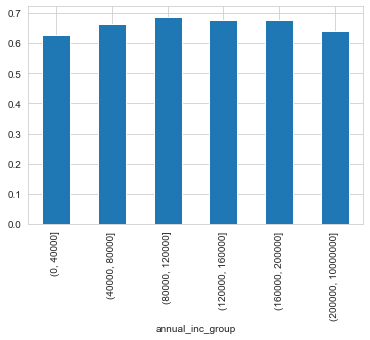

In [26]:
by_annual_inc.plot(kind = 'bar')

由上图可以看出，分组统计的方法不适用

## 3.6 债务收入比与LGD之间的关系
分别分析不同贷款等级和不同房屋状态下，债务收入比分布和LGD的关系：

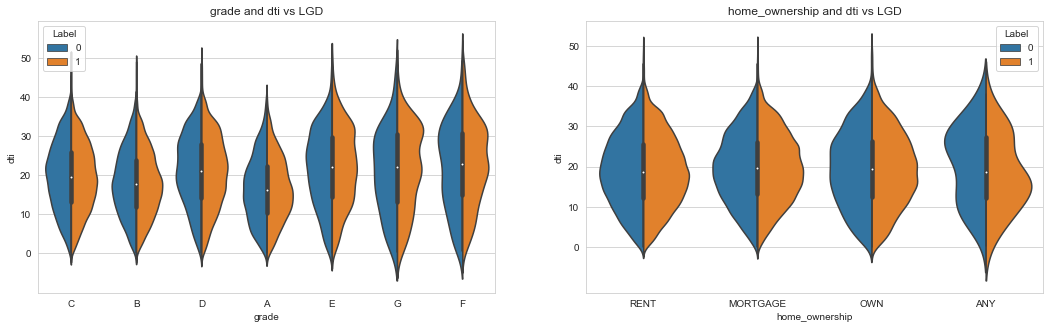

In [27]:
fig,ax = plt.subplots(1,2, figsize = (18,5))
ax[0].set_yticks(range(0,100,10))
sns.violinplot("grade","dti",hue="Label",data=train_data,split=True,ax=ax[0])
ax[0].set_title('grade and dti vs LGD') 

ax[1].set_yticks(range(0,100,10))
sns.violinplot("home_ownership","dti",hue="Label",data=train_data,split=True,ax=ax[1])
ax[1].set_title('home_ownership and dti vs LGD')
 
plt.show()



分析总体债务收入比的分布：

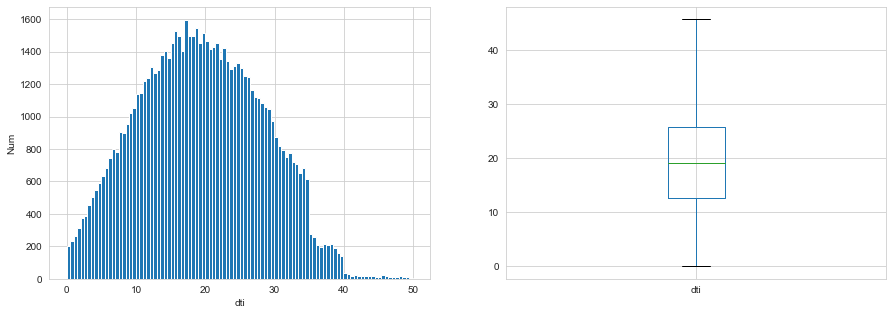

In [28]:
plt.figure(figsize=(15,5))
plt.subplot(121)
train_data['dti'].hist(bins=100)
plt.xlabel('dti')
plt.ylabel('Num')
 
plt.subplot(122)
train_data.boxplot(column='dti',showfliers=False)

plt.show()



不同债务收入比之下LGD的分布情况：

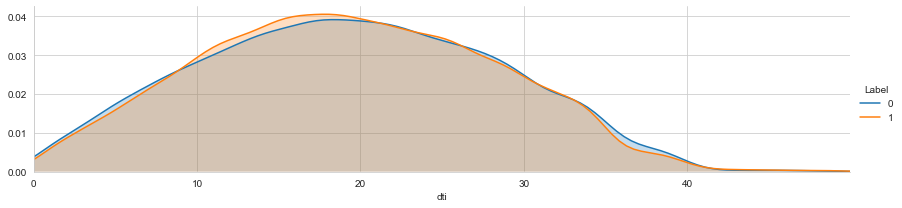

In [29]:
facet = sns.FacetGrid(train_data,hue="Label",aspect=4)
facet.map(sns.kdeplot,'dti',shade=True)
facet.set(xlim=(0,train_data['dti'].max()))
facet.add_legend()

由上图可以看出，债务收入比对于LGD有明显影响

In [30]:
print(train_data['dti'].describe())

count    75046.000000
mean        19.316569
std          8.889974
min          0.000000
25%         12.640000
50%         19.120000
75%         25.900000
max         49.930000
Name: dti, dtype: float64


 按照债务收入比，将客户划分为[0:10],[10:20],[20,30],[30,40],[40:50]的五种情况：

In [31]:
bins = [0, 10, 20, 30, 40,50]
train_data['dti_group'] = pd.cut(train_data['dti'],bins)
by_dti = train_data.groupby('dti_group')['Label'].mean()
print(by_dti)

dti_group
(0, 10]     0.647866
(10, 20]    0.671526
(20, 30]    0.658369
(30, 40]    0.647235
(40, 50]    0.746795
Name: Label, dtype: float64


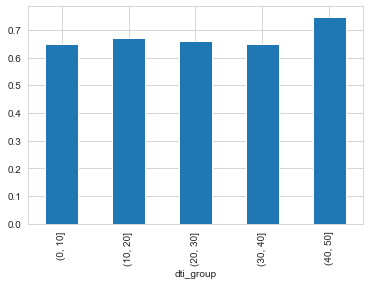

In [32]:
by_dti.plot(kind = 'bar')

由上图可知，对于债务收入比来说，分组统计的方法意义不大

## 3.7 对数据量缺失较大的几个指标与LGD的关系
mths_since_last_delinq 与 LGD的关系：

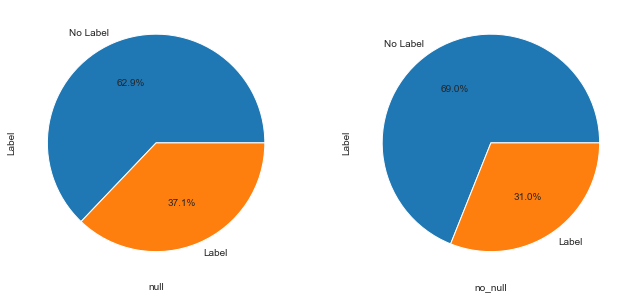

In [33]:
null_df = train_data[train_data['mths_since_last_delinq'].isnull()]
no_null_df = train_data[train_data['mths_since_last_delinq'].notnull()]

plt.figure(figsize=(11,5))
plt.subplot(121)
null_df['Label'].value_counts().plot.pie(labels=['No Label','Label'],autopct= '%1.1f%%')
plt.xlabel('null')
 
plt.subplot(122)
no_null_df['Label'].value_counts().plot.pie(labels=['No Label','Label'],autopct= '%1.1f%%')
plt.xlabel('no_null')
 
plt.show()

发现mths_since_last_delinq数据的缺失与否，对LGD并无明显影响

mths_since_last_record 与 LGD的影响：

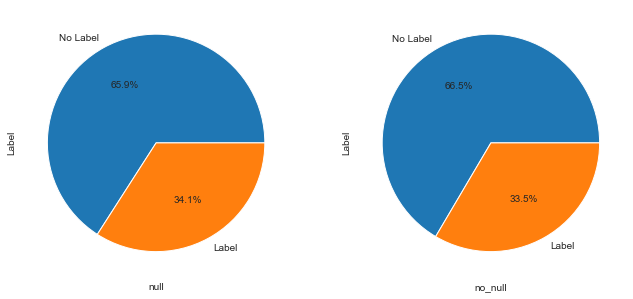

In [34]:
null_df = train_data[train_data['mths_since_last_record'].isnull()]
no_null_df = train_data[train_data['mths_since_last_record'].notnull()]

plt.figure(figsize=(11,5))
plt.subplot(121)
null_df['Label'].value_counts().plot.pie(labels=['No Label','Label'],autopct= '%1.1f%%')
plt.xlabel('null')
 
plt.subplot(122)
no_null_df['Label'].value_counts().plot.pie(labels=['No Label','Label'],autopct= '%1.1f%%')
plt.xlabel('no_null')
 
plt.show()

发现mths_since_last_record数据的缺失与否，对LGD无明显影响

mths_since_recent_bc_dlq数据的缺失 与 LGD的关系

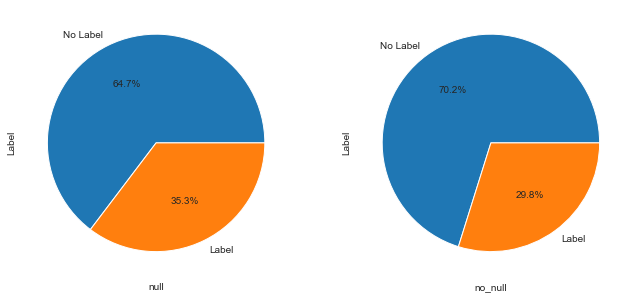

In [35]:
null_df = train_data[train_data['mths_since_recent_bc_dlq'].isnull()]
no_null_df = train_data[train_data['mths_since_recent_bc_dlq'].notnull()]

plt.figure(figsize=(11,5))
plt.subplot(121)
null_df['Label'].value_counts().plot.pie(labels=['No Label','Label'],autopct= '%1.1f%%')
plt.xlabel('null')
 
plt.subplot(122)
no_null_df['Label'].value_counts().plot.pie(labels=['No Label','Label'],autopct= '%1.1f%%')
plt.xlabel('no_null')
 
plt.show()

上图说明mths_since_recent_bc_dlq数据缺失与LGD无明显关系

mths_since_recent_revol_delinq数据缺失 与 LGD的关系：

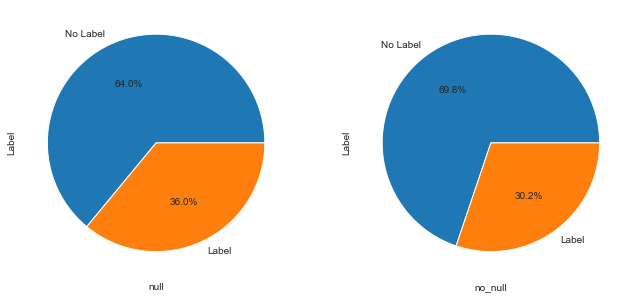

In [36]:
null_df = train_data[train_data['mths_since_recent_revol_delinq'].isnull()]
no_null_df = train_data[train_data['mths_since_recent_revol_delinq'].notnull()]

plt.figure(figsize=(11,5))
plt.subplot(121)
null_df['Label'].value_counts().plot.pie(labels=['No Label','Label'],autopct= '%1.1f%%')
plt.xlabel('null')
 
plt.subplot(122)
no_null_df['Label'].value_counts().plot.pie(labels=['No Label','Label'],autopct= '%1.1f%%')
plt.xlabel('no_null')
 
plt.show()

发现 mths_since_recent_revol_delinq数据缺失 与 LGD无明显关系

##  3.8 ‘过去信用记录’中的大量数据，进行挖掘

用PCA对大量指标进行降纬：

In [37]:
train_data=train_data.drop(['annual_inc_group','dti_group'],axis=1)

In [38]:
from sklearn.decomposition import PCA
pca = PCA()   #保留所有成分
pca.fit(train_data.drop(['mths_since_recent_revol_delinq','mths_since_recent_bc_dlq','mths_since_last_record','mths_since_last_delinq'],axis=1).iloc[:,8:].values)
pca.components_ #返回模型的各个特征向量
pca.explained_variance_ratio_ 

array([8.88838869e-01, 5.51133005e-02, 2.98514164e-02, 1.66802802e-02,
       5.53698317e-03, 1.54614605e-03, 1.07403320e-03, 1.01608498e-03,
       3.06551433e-04, 3.60118226e-05, 1.95244839e-07, 5.80252947e-08,
       2.78033955e-08, 1.76820104e-08, 1.02461713e-08, 3.18910384e-09,
       2.80683113e-09, 2.67987766e-09, 1.57372478e-09, 1.00121266e-09,
       7.53903734e-10, 5.84302539e-10, 4.58175048e-10, 2.10628586e-10,
       1.74067632e-10, 1.29460464e-10, 1.22567719e-10, 1.14556059e-10,
       1.10779135e-10, 1.05345825e-10, 6.56169773e-11, 6.09776171e-11,
       5.61373461e-11, 5.16137732e-11, 4.77815097e-11, 3.93779733e-11,
       3.80742970e-11, 3.22741278e-11, 3.01334063e-11, 2.72860127e-11,
       2.23011142e-11, 1.92139398e-11, 1.65587080e-11, 1.48391468e-11,
       1.33351519e-11, 1.07631067e-11, 9.97556112e-12, 8.62594245e-12,
       4.42605767e-12, 3.74161343e-12, 2.56335390e-12, 2.42177907e-12,
       1.75521990e-12, 6.89817320e-13, 6.62063020e-13, 3.15674874e-13,
      

当选取前3个主成分时，累计贡献率已经达到97.37%，所以选取前3个主成分进行计算。

# 4 特征工程

重新载入数据：

In [39]:
train_df_org = pd.read_csv(r'/Users/jiiangzhongy/Desktop/金融科技建模比赛/LGD training.csv')
test_df_org = pd.read_csv(r'/Users/jiiangzhongy/Desktop/金融科技建模比赛/LGD TEST.csv')
test_df_org['Label'] = 0
test_df_org.index=pd.Series(range(75046,94888))
combined_train_test = train_df_org.append(test_df_org)   #75046+19842=94888rows, 73columns
combined_train_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 94888 entries, 0 to 94887
Data columns (total 73 columns):
Label                             94888 non-null int64
acc_now_delinq                    94888 non-null int64
acc_open_past_24mths              94888 non-null int64
all_util                          94874 non-null float64
annual_inc                        94888 non-null float64
avg_cur_bal                       94885 non-null float64
bc_open_to_buy                    93687 non-null float64
bc_util                           93642 non-null float64
chargeoff_within_12_mths          94888 non-null int64
collections_12_mths_ex_med        94888 non-null int64
delinq_2yrs                       94888 non-null int64
delinq_amnt                       94888 non-null int64
dti                               94888 non-null float64
fico_range_high                   94888 non-null int64
grade                             94888 non-null object
home_ownership                    94888 non-null obje

## 4.1 对分类变量进行处理

### 4.1.1 grade

将grade特征 factorize化：

In [40]:
combined_train_test['grade'] = pd.factorize(combined_train_test['grade'])[0]

###  4.1.2 home_ownership

将home_ownership特征 factorize化：

In [41]:
combined_train_test['home_ownership'] = pd.factorize(combined_train_test['home_ownership'])[0]

###  4.1.3 purpose

将 purpose特征 factorize化：

In [42]:
combined_train_test['purpose'] = pd.factorize(combined_train_test['purpose'])[0]

## 4.2 对征信记录中的特征进行处理

In [43]:
#将['revol_util']数据类型改为 float
for i in range(0,len(combined_train_test['revol_util'])):
    if type(combined_train_test.loc[i]['revol_util'])== str:
        combined_train_test.loc[i,'revol_util']=round(float(combined_train_test.loc[i]['revol_util'][:-1])/100,4)

从前面的EDA可知，贷款评级对LGD影响很大，所以在填补缺失值时，使用对应评级的平均数进行填补：

In [44]:
for i in ['open_acc_6m','open_act_il','open_il_12m','open_il_24m',
          'mths_since_rcnt_il','total_bal_il','il_util','open_rv_12m'
          ,'open_rv_24m','max_bal_bc','all_util','inq_fi','total_cu_tl'
         ,'inq_last_12m','avg_cur_bal','bc_open_to_buy','bc_util','mo_sin_old_il_acct'
         ,'mths_since_recent_bc','mths_since_recent_inq','num_tl_120dpd_2m','percent_bc_gt_75','revol_util']:
    combined_train_test[i] = combined_train_test[[i]].fillna(combined_train_test.groupby('grade').transform(np.mean))
    

从前面EDA可以得知，['mths_since_recent_revol_delinq','mths_since_recent_bc_dlq','mths_since_last_record','mths_since_last_delinq']可以舍弃

In [45]:
combined_train_test=combined_train_test.drop(['mths_since_recent_revol_delinq','mths_since_recent_bc_dlq','mths_since_last_record','mths_since_last_delinq'],axis=1)


从前面EDA可知，对于信用记录的特征，使用PCA降维是有效的方法：

In [46]:
pca_train_test=combined_train_test

from sklearn.decomposition import PCA
pca = PCA(3)   #由EDA可知，保留前三个成分
pca.fit(pca_train_test.drop(['Label','loan_amnt','grade','home_ownership','annual_inc','purpose','dti'],axis=1).values)
low_d = pca.transform(pca_train_test.drop(['Label','loan_amnt','grade','home_ownership','annual_inc','purpose','dti'],axis=1).values)


## 4.3 特征间相关性分析

我们挑选一些主要的特征，生成特征之间的关联图，查看特征与特征之间的相关性：

In [47]:
combined_train_test.loc[:,'passed_credit1']=low_d[:,0]
combined_train_test.loc[:,'passed_credit2']=low_d[:,1]
combined_train_test.loc[:,'passed_credit3']=low_d[:,2]

(9.0, 0.0)

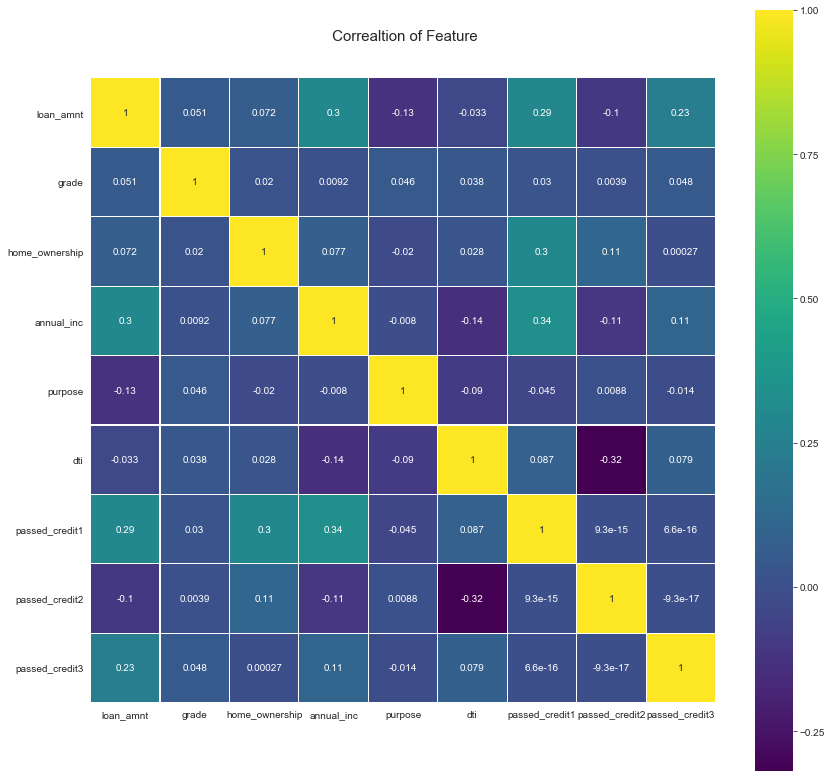

In [48]:
Correlation = pd.DataFrame(combined_train_test[['loan_amnt','grade','home_ownership','annual_inc','purpose','dti','passed_credit1','passed_credit2','passed_credit3']])

colormap = plt.cm.viridis
plt.figure(figsize=(14,14))
plt.title(' Correaltion of Feature',y=1.05,size=15)
ax = sns.heatmap(Correlation.astype(float).corr(),linewidths=0.1,vmax=1.0,square=True,cmap=colormap,linecolor='white',annot=True)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

特征之间的数据分布图：

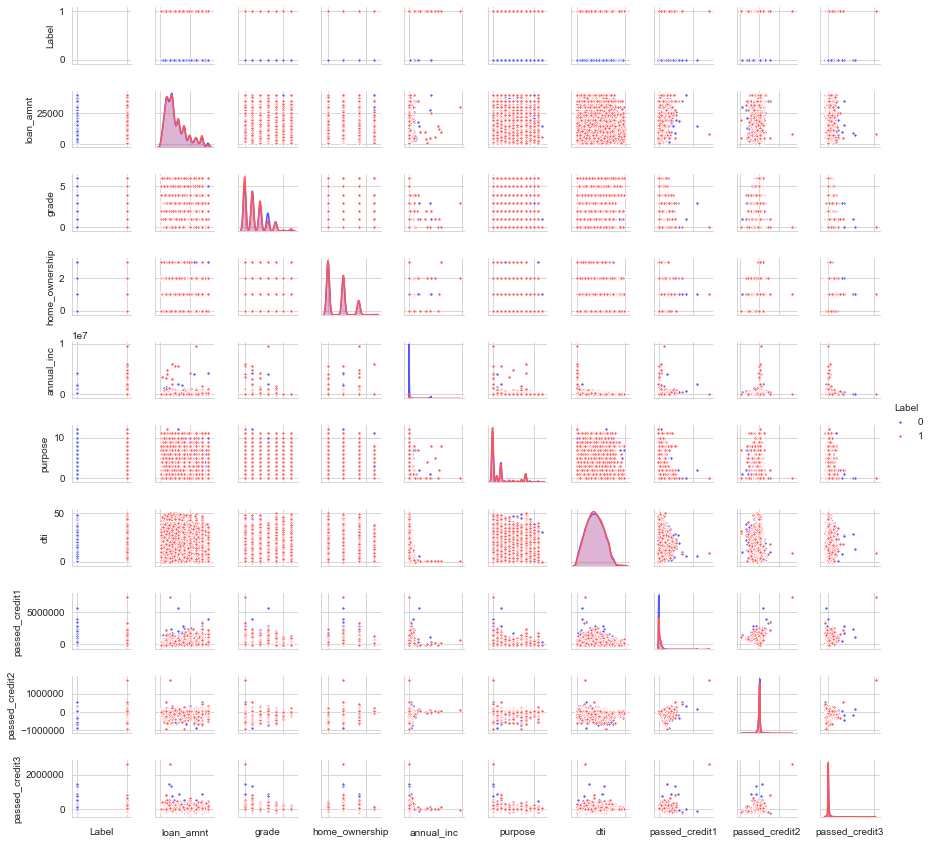

In [49]:
g = sns.pairplot(combined_train_test[[u'Label',u'loan_amnt',u'grade',u'home_ownership',u'annual_inc',u'purpose',u'dti',
                                      u'passed_credit1',u'passed_credit2',u'passed_credit3']],hue='Label',
                                      palette = 'seismic',size=1.2,diag_kind ='kde',diag_kws=
                                      dict(shade=True),plot_kws=dict(s=10))
g.set(xticklabels=[])



## 4.4 输入模型前的一些处理

将 loan_amnt, annual_inc,dti,passed_credit1,passed_credit2,passed_credit3进行正则化：

In [50]:
from sklearn import preprocessing
scale_age_fare = preprocessing.StandardScaler().fit(combined_train_test[['loan_amnt', 'annual_inc','dti','passed_credit1','passed_credit2','passed_credit3']])
combined_train_test[['loan_amnt', 'annual_inc','dti','passed_credit1','passed_credit2','passed_credit3']] = scale_age_fare.transform(combined_train_test[['loan_amnt', 'annual_inc','dti','passed_credit1','passed_credit2','passed_credit3']])



丢弃无用特征：

In [51]:
combined_data_backup = combined_train_test

combined_train_test=combined_data_backup.loc[:,['Label','loan_amnt','grade','home_ownership','annual_inc','purpose','dti','passed_credit1','passed_credit2','passed_credit3']]



对 purpose grade home_ownership进行one-hot编码，也就是dummy处理：

In [52]:
for i in ['purpose','grade','home_ownership']:
    emb_dummies_df = pd.get_dummies(combined_train_test[i],prefix=combined_train_test[[i]].columns[0])
    combined_train_test = pd.concat([combined_train_test, emb_dummies_df], axis=1)

将训练数据与测试数据分开：

In [53]:
train_data = combined_train_test[:75046]
test_data = combined_train_test[75046:]
test_data.index=pd.Series(range(0,19842))

lgd_train_data_X = train_data.drop(['Label'],axis=1)
lgd_train_data_Y = train_df_org['Label']
lgd_test_data_X = test_data.drop(['Label'],axis=1)

print(lgd_train_data_X.info())
print(lgd_train_data_Y.shape)


<class 'pandas.core.frame.DataFrame'>
Int64Index: 75046 entries, 0 to 75045
Data columns (total 33 columns):
loan_amnt           75046 non-null float64
grade               75046 non-null int64
home_ownership      75046 non-null int64
annual_inc          75046 non-null float64
purpose             75046 non-null int64
dti                 75046 non-null float64
passed_credit1      75046 non-null float64
passed_credit2      75046 non-null float64
passed_credit3      75046 non-null float64
purpose_0           75046 non-null uint8
purpose_1           75046 non-null uint8
purpose_2           75046 non-null uint8
purpose_3           75046 non-null uint8
purpose_4           75046 non-null uint8
purpose_5           75046 non-null uint8
purpose_6           75046 non-null uint8
purpose_7           75046 non-null uint8
purpose_8           75046 non-null uint8
purpose_9           75046 non-null uint8
purpose_10          75046 non-null uint8
purpose_11          75046 non-null uint8
purpose_12        

# 5 使用机器学习模型

## 5.1 利用不同的模型来对特征进行筛选，选出较为重要的特征：

In [54]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor

### 5.1.1 RandomForest

In [55]:
param_rf = {'n_estimators': 500, 'min_samples_split': 3, 'max_depth': 20}
model_rf = RandomForestRegressor(**param_rf)

model_rf.fit(lgd_train_data_X, lgd_train_data_Y)

print('Top N Features RF Train Score:' +
      str(model_rf.score(lgd_train_data_X, lgd_train_data_Y)))

print(list(lgd_train_data_X))
feature_imp_sorted_rf = pd.DataFrame({
    'feature':
    list(lgd_train_data_X),
    'importance':
    model_rf.feature_importances_
}).sort_values('importance', ascending=False)
features_top_n_rf = feature_imp_sorted_rf.head(10)['feature']
print('Sample 10 Features from RF Regressor')
print(str(features_top_n_rf[:10]))

Top N Features RF Train Score:0.5222740860095596
['loan_amnt', 'grade', 'home_ownership', 'annual_inc', 'purpose', 'dti', 'passed_credit1', 'passed_credit2', 'passed_credit3', 'purpose_0', 'purpose_1', 'purpose_2', 'purpose_3', 'purpose_4', 'purpose_5', 'purpose_6', 'purpose_7', 'purpose_8', 'purpose_9', 'purpose_10', 'purpose_11', 'purpose_12', 'grade_0', 'grade_1', 'grade_2', 'grade_3', 'grade_4', 'grade_5', 'grade_6', 'home_ownership_0', 'home_ownership_1', 'home_ownership_2', 'home_ownership_3']
Sample 10 Features from RF Regressor
8     passed_credit3
5                dti
7     passed_credit2
6     passed_credit1
3         annual_inc
0          loan_amnt
25           grade_3
4            purpose
2     home_ownership
11         purpose_2
Name: feature, dtype: object


### 5.1.2 AbaBoost

In [56]:
param_ada = {'n_estimators': 500, 'learning_rate': 0.01}
model_ada = AdaBoostRegressor(**param_ada)

model_ada.fit(lgd_train_data_X, lgd_train_data_Y)

print('Top N Features ADA Train Score:' +
      str(model_ada.score(lgd_train_data_X, lgd_train_data_Y)))

print(list(lgd_train_data_X))
feature_imp_sorted_ada = pd.DataFrame({
    'feature':
    list(lgd_train_data_X),
    'importance':
    model_ada.feature_importances_
}).sort_values('importance', ascending=False)
features_top_n_ada = feature_imp_sorted_ada.head(10)['feature']
print('Sample 10 Feeatures from ADA Regressor')
print(str(features_top_n_ada[:10]))

Top N Features ADA Train Score:0.019225673307355584
['loan_amnt', 'grade', 'home_ownership', 'annual_inc', 'purpose', 'dti', 'passed_credit1', 'passed_credit2', 'passed_credit3', 'purpose_0', 'purpose_1', 'purpose_2', 'purpose_3', 'purpose_4', 'purpose_5', 'purpose_6', 'purpose_7', 'purpose_8', 'purpose_9', 'purpose_10', 'purpose_11', 'purpose_12', 'grade_0', 'grade_1', 'grade_2', 'grade_3', 'grade_4', 'grade_5', 'grade_6', 'home_ownership_0', 'home_ownership_1', 'home_ownership_2', 'home_ownership_3']
Sample 10 Feeatures from ADA Regressor
0         loan_amnt
1             grade
2    home_ownership
3        annual_inc
4           purpose
5               dti
6    passed_credit1
7    passed_credit2
8    passed_credit3
9         purpose_0
Name: feature, dtype: object


### 5.1.3 ExtraTree

In [57]:
param_et = {'n_estimators': 500, 'min_samples_split': 4, 'max_depth': 20}
model_et = ExtraTreesRegressor(**param_et)

model_et.fit(lgd_train_data_X, lgd_train_data_Y)

print('Top N Features ET Train Score:' +
      str(model_et.score(lgd_train_data_X, lgd_train_data_Y)))

print(list(lgd_train_data_X))
feature_imp_sorted_et = pd.DataFrame({
    'feature':
    list(lgd_train_data_X),
    'importance':
    model_et.feature_importances_
}).sort_values('importance', ascending=False)
features_top_n_et = feature_imp_sorted_et.head(10)['feature']
print('Sample 10 Feeatures from ET Regressor')
print(str(features_top_n_et[:10]))

Top N Features ET Train Score:0.3883189058802433
['loan_amnt', 'grade', 'home_ownership', 'annual_inc', 'purpose', 'dti', 'passed_credit1', 'passed_credit2', 'passed_credit3', 'purpose_0', 'purpose_1', 'purpose_2', 'purpose_3', 'purpose_4', 'purpose_5', 'purpose_6', 'purpose_7', 'purpose_8', 'purpose_9', 'purpose_10', 'purpose_11', 'purpose_12', 'grade_0', 'grade_1', 'grade_2', 'grade_3', 'grade_4', 'grade_5', 'grade_6', 'home_ownership_0', 'home_ownership_1', 'home_ownership_2', 'home_ownership_3']
Sample 10 Feeatures from ET Regressor
8       passed_credit3
5                  dti
3           annual_inc
0            loan_amnt
7       passed_credit2
6       passed_credit1
25             grade_3
30    home_ownership_1
4              purpose
11           purpose_2
Name: feature, dtype: object


### 5.1.4 GradientBoosting

In [58]:
param_gb = {'n_estimators': 500, 'learning_rate': 0.1, 'max_depth': 20}
model_gb = GradientBoostingRegressor(**param_gb)

model_gb.fit(lgd_train_data_X, lgd_train_data_Y)

print('Top N Features GB Train Score:' +
      str(model_gb.score(lgd_train_data_X, lgd_train_data_Y)))

print(list(lgd_train_data_X))
feature_imp_sorted_gb = pd.DataFrame({
    'feature':
    list(lgd_train_data_X),
    'importance':
    model_gb.feature_importances_
}).sort_values('importance', ascending=False)
features_top_n_gb = feature_imp_sorted_gb.head(10)['feature']
print('Sample 10 Feeatures from GB Regressor')
print(str(features_top_n_gb[:10]))

Top N Features GB Train Score:0.999948142482667
['loan_amnt', 'grade', 'home_ownership', 'annual_inc', 'purpose', 'dti', 'passed_credit1', 'passed_credit2', 'passed_credit3', 'purpose_0', 'purpose_1', 'purpose_2', 'purpose_3', 'purpose_4', 'purpose_5', 'purpose_6', 'purpose_7', 'purpose_8', 'purpose_9', 'purpose_10', 'purpose_11', 'purpose_12', 'grade_0', 'grade_1', 'grade_2', 'grade_3', 'grade_4', 'grade_5', 'grade_6', 'home_ownership_0', 'home_ownership_1', 'home_ownership_2', 'home_ownership_3']
Sample 10 Feeatures from GB Regressor
8     passed_credit3
5                dti
7     passed_credit2
6     passed_credit1
3         annual_inc
0          loan_amnt
4            purpose
25           grade_3
1              grade
2     home_ownership
Name: feature, dtype: object


 ### 5.1.5 DecisionTree

In [59]:
param_dt = {'min_samples_split': 4, 'max_depth': 20}
model_dt = DecisionTreeRegressor(**param_dt)

model_dt.fit(lgd_train_data_X, lgd_train_data_Y)

print('Top N Features DT Train Score:' +
      str(model_dt.score(lgd_train_data_X, lgd_train_data_Y)))

print(list(lgd_train_data_X))
feature_imp_sorted_dt = pd.DataFrame({
    'feature':
    list(lgd_train_data_X),
    'importance':
    model_dt.feature_importances_
}).sort_values('importance', ascending=False)
features_top_n_dt = feature_imp_sorted_dt.head(10)['feature']
print('Sample 10 Feeatures from DT Regressor')
print(str(features_top_n_dt[:10]))

Top N Features DT Train Score:0.4259016174149012
['loan_amnt', 'grade', 'home_ownership', 'annual_inc', 'purpose', 'dti', 'passed_credit1', 'passed_credit2', 'passed_credit3', 'purpose_0', 'purpose_1', 'purpose_2', 'purpose_3', 'purpose_4', 'purpose_5', 'purpose_6', 'purpose_7', 'purpose_8', 'purpose_9', 'purpose_10', 'purpose_11', 'purpose_12', 'grade_0', 'grade_1', 'grade_2', 'grade_3', 'grade_4', 'grade_5', 'grade_6', 'home_ownership_0', 'home_ownership_1', 'home_ownership_2', 'home_ownership_3']
Sample 10 Feeatures from DT Regressor
5                dti
6     passed_credit1
8     passed_credit3
7     passed_credit2
3         annual_inc
0          loan_amnt
25           grade_3
4            purpose
2     home_ownership
11         purpose_2
Name: feature, dtype: object


 merge the three models

In [60]:
features_top_n = pd.concat([
    features_top_n_rf, features_top_n_ada, features_top_n_et,
    features_top_n_gb, features_top_n_dt
],
                           ignore_index=True).drop_duplicates()
features_importance = pd.concat([
    feature_imp_sorted_rf, feature_imp_sorted_ada, feature_imp_sorted_et,
    feature_imp_sorted_gb, feature_imp_sorted_dt
],
                                ignore_index=True)

## 5.2 筛选特征

In [61]:
feature_to_pick = 30

lgd_train_data_X = pd.DataFrame(lgd_train_data_X[features_top_n])
lgd_test_data_X = pd.DataFrame(lgd_test_data_X[features_top_n])

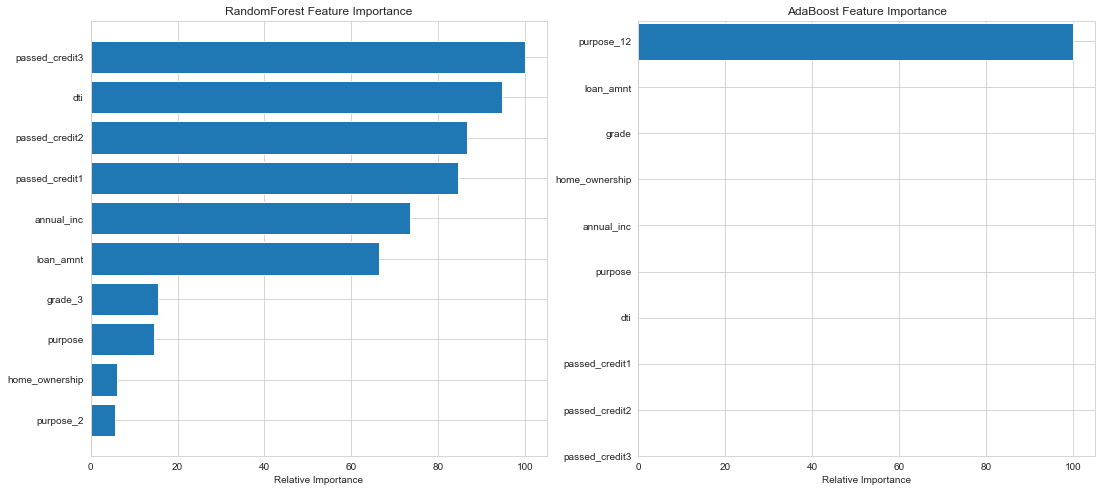

In [62]:
# 用视图可视化不同算法筛选的特征排序：
rf_feature_imp = features_importance[:10]
Ada_feature_imp = features_importance[32:32 + 10].reset_index(drop=True)

# make importances relative to max importance
rf_feature_importance = 100.0 * (rf_feature_imp['importance'] /
                                 rf_feature_imp['importance'].max())
Ada_feature_importance = 100.0 * (Ada_feature_imp['importance'] /
                                  Ada_feature_imp['importance'].max())

# Get the indexes of all features over the importance threshold
rf_important_idx = np.where(rf_feature_importance)[0]
Ada_important_idx = np.where(Ada_feature_importance)[0]

# Adapted from http://scikit-learn.org/stable/auto_examples/ensemble/plot_gradient_boosting_regression.html
pos = np.arange(rf_important_idx.shape[0]) + .5

plt.figure(1, figsize=(18, 8))

plt.subplot(121)
plt.barh(pos, rf_feature_importance[rf_important_idx][::-1])
plt.yticks(pos, rf_feature_imp['feature'][::-1])
plt.xlabel('Relative Importance')
plt.title('RandomForest Feature Importance')

plt.subplot(122)
plt.barh(pos, Ada_feature_importance[Ada_important_idx][::-1])
plt.yticks(pos, Ada_feature_imp['feature'][::-1])
plt.xlabel('Relative Importance')
plt.title('AdaBoost Feature Importance')

plt.show()

## 5.3 模型融合：Stacking 框架融合

 Stacking框架融合：这里使用了两层的模型融合
 Level 1使用了：Random Forest、AdaBoost、ExtraTrees、GBDT、Decision Tree、KNN、SVM，一共7个模型
 Level 2使用了XGBoost，使用第一层预测的结果作为特征对最终的结果进行预测。
### 5.3.1 Level 1：建立输出fold预测方法
 Stacking框架是堆叠使用基础分类器的预测作为对二级模型的训练的输入。然而，不能简单地在全部训练数据上训练基本模型，产生预测，输出用于第二层的训练。
 对每个基学习器使用K-fold，将Kge模型对Valid Set的预测结果拼起来，作为下一层学习器的输入。
 所以这里建立输出fold预测方法：

In [63]:
from sklearn.model_selection import KFold
 
# Some useful parameters which will come in handy later on
ntrain = lgd_train_data_X.shape[0]
ntest = lgd_test_data_X.shape[0]
SEED = 0 #for reproducibility
NFOLDS = 7 # set folds for out-of-fold prediction
kf = KFold(n_splits = NFOLDS,random_state=SEED,shuffle=False)
 
def get_out_fold(clf,x_train,y_train,x_test):
    oof_train = np.zeros((ntrain,))
    oof_test = np.zeros((ntest,))
    oof_test_skf = np.empty((NFOLDS,ntest))
    
    for i, (train_index,test_index) in enumerate(kf.split(x_train)):
        x_tr = x_train[train_index]
        y_tr = y_train[train_index]
        x_te = x_train[test_index]
        
        clf.fit(x_tr,y_tr)
        
        oof_train[test_index] = clf.predict(x_te)
        oof_test_skf[i,:] = clf.predict(x_test)
        
    oof_test[:] = oof_test_skf.mean(axis=0)
    return oof_train.reshape(-1,1),oof_test.reshape(-1,1)



 构建不同的基学习器，这里使用了RandomForest、AdaBoost、ExtraTrees、GBDT、DecisionTree、KNN、SVM七个基学习器：（这里的模型可以使用如上面的GridSearch方法对模型的超参数进行搜索选择）

In [64]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
 
rf = RandomForestRegressor(n_estimators=500,warm_start=True,max_features='sqrt',max_depth=6,min_samples_split=3,min_samples_leaf=2,n_jobs=-1,verbose=0)
 
ada = AdaBoostRegressor(n_estimators=500,learning_rate=0.1)
 
et = ExtraTreesRegressor(n_estimators=500,n_jobs=-1,max_depth=8,min_samples_leaf=2,verbose=0)
 
gb = GradientBoostingRegressor(n_estimators=500,learning_rate=0.008,min_samples_split=3,min_samples_leaf=2,max_depth=5,verbose=0)
 
dt = DecisionTreeRegressor(max_depth=8)
 
knn = KNeighborsRegressor(n_neighbors=2)
 
svm = SVC(kernel='linear',C=0.025)



 将pandas转换为arrays：
 Create Numpy arrays of train,test and target(Survived) dataframes to feed into our models

In [65]:
x_train = lgd_train_data_X.values   #Creates an array of the train data
x_test = lgd_test_data_X.values   #Creates an array of the test data
y_train = lgd_train_data_Y.values

# Create our OOF train and test predictions.These base result will be used as new featurs
rf_oof_train,rf_oof_test = get_out_fold(rf,x_train,y_train,x_test)  # Random Forest
ada_oof_train,ada_oof_test = get_out_fold(ada,x_train,y_train,x_test)  # AdaBoost
et_oof_train,et_oof_test = get_out_fold(et,x_train,y_train,x_test)  # Extra Trees
gb_oof_train,gb_oof_test = get_out_fold(gb,x_train,y_train,x_test)  # Gradient Boost
dt_oof_train,dt_oof_test = get_out_fold(dt,x_train,y_train,x_test)  #Decision Tree
knn_oof_train,knn_oof_test = get_out_fold(knn,x_train,y_train,x_test)  # KNeighbors
svm_oof_train,svm_oof_test = get_out_fold(svm,x_train,y_train,x_test)  # Support Vector
 
print("Training is complete")



Training is complete


### 5.3.2 Level 2：利用XGBoost，使用第一层预测的结果作为特征对最终的结果进行预测。
## 5.4 得出预测结果，并提交预测文件

In [66]:
x_train = np.concatenate((rf_oof_train, ada_oof_train, et_oof_train,
                          gb_oof_train, dt_oof_train, knn_oof_train, svm_oof_train), axis=1)
x_test = np.concatenate((rf_oof_test, ada_oof_test, et_oof_test,
                         gb_oof_test, dt_oof_test, knn_oof_test, svm_oof_test), axis=1)

In [68]:
from xgboost import XGBRegressor  # xgboost库的下载过程比较复杂，直接pip无法使用，这个链接有详细处理方法：https://blog.csdn.net/weixin_41938903/article/details/102898923?utm_medium=distribute.pc_relevant.none-task-blog-BlogCommendFromMachineLearnPai2-4.nonecase&depth_1-utm_source=distribute.pc_relevant.none-task-blog-BlogCommendFromMachineLearnPai2-4.nonecase


gbm = XGBRegressor(n_estimators=200, max_depth=4, min_child_weight=2, gamma=0.9, subsample=0.8,
                   colsample_bytree=0.8, objective='binary:logistic', nthread=-1, scale_pos_weight=1).fit(x_train, y_train)
predictions = gbm.predict(x_test)

StackingSubmission = pd.DataFrame(
    {'贷款id': range(1, 19843), 'predict': predictions})
StackingSubmission.to_excel(r'41819045.xlsx', index=False)  # 将结果存为41819045.csv